# Домашнее задание №3. 
*Кирилл Семенов, БКЛ162*

Описание задания:

Выберите одну из предложенных лексем: *свет, острый, лук, замок*.

* Выберите 2-3 значения лексемы по словарю (рекомендую использовать МАС, обязательно напишите, каким словарем пользовались). Для каждого значения придумайте несколько "диагностических" слов (которые сигнализируют о реализации одного из значений в контексте): например, ключ — вода / дверь. Подберите по НКРЯ контексты для выбранной лексемы, содержащие диагностические слова. Таким образом, получается размеченный тестсет.

* Для каждого контекста определите значение автоматически — с помощью AdaGram / ELMo на выбор. В случае с AdaGram вы сразу получаете какой-то номер значения, с ELMo — нужно кластеризовать.

* Возьмите словарные толкования для каждого значения и припишите ему значение автоматически тем же способом, что и в п.2.

* Придумайте и реализуйте способ соотнести толкования с значениями с помощью тезауруса (Wiki_ru_wordnet / РуТез).

* Оцените accuracy — в какой доле контекстов автоматически определенно значение для контекста совпадает с автоматически определенным значением толкования.

Критерии оценки:
по 2 балла на каждый пункт

Формат сдачи задания:
Jupyter-notebook на гитхабе.

Дедлайн:
9 декабря 2019 10:00мск



# Импорты и инсталляции

In [0]:
!pip install git+https://github.com/lopuhin/python-adagram.git
!pip install allennlp

  Cloning https://github.com/lopuhin/python-adagram.git to /tmp/pip-req-build-kfuzzz_k
  Running command git clone -q https://github.com/lopuhin/python-adagram.git /tmp/pip-req-build-kfuzzz_k
  Created wheel for adagram: filename=adagram-0.0.1-cp36-cp36m-linux_x86_64.whl size=464614 sha256=80ced06f113d3489378baf548ea0a49137cd193ae53b7b1e6195295463fc12cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-vgysl7sk/wheels/11/0f/46/f5df96670df8f7973b4c2311ffc9b02e435a7bd3207f992c4d
Successfully built adagram
     |████████████████████████████████| 7.6MB 5.5MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 194kB 47.1MB/s 
     |████████████████████████████████| 256kB 50.0MB/s 
     |████████████████████████████████| 245kB 40.8MB/s 
     |████████████████████████████████| 133kB 50.0MB/s 
     |████████████████████████████████| 163kB 51.4MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 675kB 45

In [0]:
!wget 'https://www.dropbox.com/s/lsp4k371dihe0li/all.a010.p10.d300.w5.m100.nonorm.slim.joblib'

--2019-12-09 21:30:04--  https://www.dropbox.com/s/lsp4k371dihe0li/all.a010.p10.d300.w5.m100.nonorm.slim.joblib
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lsp4k371dihe0li/all.a010.p10.d300.w5.m100.nonorm.slim.joblib [following]
--2019-12-09 21:30:04--  https://www.dropbox.com/s/raw/lsp4k371dihe0li/all.a010.p10.d300.w5.m100.nonorm.slim.joblib
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc955d694d8b6c682266768cfade.dl.dropboxusercontent.com/cd/0/inline/At4oelFKEoMyCvPPVM5jizLUNpO3_hl5PvV7Ca1mchFDQJVIWv9MKoSj2ampJrA5zO7cALTf2P2q1SRIm2ACkzj0SwZwRowwq4AtqGAxkm-xYAR3KL_4G3EHpS2yPZmOKq8/file# [following]
--2019-12-09 21:30:05--  https://uc955d694d8b6c682266768cfade.dl.dropboxusercontent.com/cd/0/inline/At4oelFKEoMyCvP

In [0]:
!pip install pymorphy2

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 7.1MB 11.4MB/s 


In [0]:
import adagram
from allennlp.commands.elmo import ElmoEmbedder
import pandas as pd
from lxml import html
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
import tqdm
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import *
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')
stops = set(stopwords.words('russian'))

In [0]:
def normalize_pm(text):
    words = [morph.parse(word)[0].normal_form for word in tokenize(text) if word]
    return words

def tokenize(text):
    return token.tokenize(text)

In [0]:
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

# Работаем!
## §1


Выбранное слово - свет.
Основные значения:
* Свет1:
  * Лучистая  энергия,  делающая  окружающий мир видимым;электромагнитные  волны  в интервале  частот, воспринимаемых глазом. *Диагностические слова:* **источник, излучение, видимый, луч**
  * Освещенность, состояние, когда светло. *Диагностические слова:* **тусклый, яркий, сияние, дневной**
* Свет2:
  * Земля, Вселенная, а  также люди, ее  населяющие. *Диагностические слова:* **мир, Земля, путешествие, появиться**

Использованный источник - толковый словарь Ожегова, изд. 1992 г. (http://lib.ru/DIC/OZHEGOW/ozhegow_s_q.txt)

In [0]:
#Свет1.1:
physical_light_sentences = ['Даже два одинаковых рисунка при разных источниках света выглядят по-разному.',
                            'Источником какого света для нас являются сумерки, утренние и вечерние зори?',
                            'Поскольку водяной пар хорошо поглощает ближнее инфракрасное излучение, но практически прозрачен для видимого света, астрономы смогли определить его присутствие в атмосфере экзопланет.',
                            'Ток нагревает проводник (например, вольфрамовую спираль), отчего тот испускает излучение, в том числе видимый свет.',
                            'Вот на излучение (свет, например) это точно работает.',
                            'Светодиод имеет другой принцип излучения света, который требует, прежде всего, гораздо меньшей потребляемой мощности.',
                            'Длина волны зелёного луча света в воздухе равна длине волны красного луча в воде.',
                            'окна надо было чуть ли не заклеить чёрной бумагой, чтоб ни один луч света не проникал']

#Свет1.2:
static_light_sentences = ['в окнах безмолвно отражается залитая тусклым жёлтым светом разорённая нищета, так или иначе чувствуешь бесприютность.',
                          'Перед ним в тусклом жёлтом свете стояла, придерживая полы халата, Мариетта Ивановна.',
                          'В летний день, когда всё залито ярким светом, зрачки кошки резко сужаются, превращаясь в тонкие щёлки.',
                          'Старик поморгал, словно от яркого света, прикрыл худыми ладонями лицо, потом повернулся на бок к стене, будто подремать решил.',
                          'И вдруг словно свет полярного сияния замерцал по рядам: Сталин умер!',
                          'Где живость красок и сияние света?',
                          'Рассказывали, расспрашивали, глядели друг на дружку при дневном уже свете.',
                          'Но это ощущение обманчиво, ибо только при дневном свете можно разглядеть, насколько грязными они становятся через неделю пребывания под землёй.']

#Свет2:
world_light_sentences = ['Не согласен больше с этой жизнью, этим миром, этим светом, слишком не белым.',
                         'Герострат сжёг храм Артемиды ― одно из семи чудес света Древнего мира.',
                         'Когда-то Новый Свет Земли был без лишних споров поделен между двумя сверхдержавами своего времени, Испанией и Португалией.',
                         'И о том, что перед смертью, прощаясь с белым светом, сторонами Земли и иным прижизненным окружением, они называли по именам всех своих детей…',
                         'Он употребил его в отчете о путешествии вокруг света, опубликованном в 1773 году.',
                         'В него вошли журналы: «Наука и жизнь», «Знание ― сила», «Путешествие по свету», «Химия и жизнь XXI век».',
                         'В результате данного ОЕМ-соглашения на свет появились первые модели серии StorEdge 3000.',
                         'Ирина закрывала глаза и молилась, чтобы ребёнок не появился на свет.']

## §2

Для начала посмотрим, какую дизамбигуацию нам дает сферический адаграм в вакууме.

In [0]:
vm.word_sense_probs('свет')

[(0, 0.10958200299171707),
 (1, 0.28889593098959726),
 (2, 0.22618001157825376),
 (3, 0.11159016453333064),
 (4, 0.13259494691818238),
 (5, 0.13115681995171802)]

In [0]:
collocates_to_types = {} #создадим на будущее словарь, чтобы потом использовать его для оценки accuracy и т.д.
collocates_to_types_by_word = {}
for i in range(5):
  print(i)
  best_10 = vm.sense_neighbors('свет', i) 
  print(best_10)
  collocates_to_types[tuple(best_10)] = i
  print('__________________')

  for word in best_10:
    w = word[0]
    if w in collocates_to_types_by_word.keys():
      del collocates_to_types_by_word[w]
    else:
      collocates_to_types_by_word[w] = i


0
[('луч', 1, 0.74209464), ('световой', 1, 0.7118988), ('рассеивать', 0, 0.67998713), ('излучение', 2, 0.6780513), ('спектр', 3, 0.6602384), ('излучать', 0, 0.65674734), ('монохроматический', 0, 0.65437716), ('интенсивность', 0, 0.65404993), ('радиоволна', 0, 0.6538729), ('фотон', 0, 0.6513885)]
__________________
1
[('сияние', 0, 0.8441459), ('бледный', 0, 0.77602106), ('отблеск', 0, 0.77482814), ('неяркий', 0, 0.77332705), ('свечение', 1, 0.7703127), ('мерцание', 0, 0.7677323), ('отсвет', 0, 0.7609194), ('тусклый', 0, 0.754006), ('блик', 1, 0.74678814), ('блик', 0, 0.74521506)]
__________________
2
[('земля', 1, 0.48637575), ('похожий', 0, 0.4651765), ('походить', 0, 0.43085188), ('мир', 3, 0.42383873), ('планета', 4, 0.40554008), ('край', 4, 0.38195944), ('диво', 2, 0.37982717), ('сцена', 1, 0.37856242), ('способный', 3, 0.3751216), ('жениться', 1, 0.373528)]
__________________
3
[('появляться', 1, 0.4725476), ('переиздание', 1, 0.46436742), ('выходить', 0, 0.45973048), ('издание', 

In [0]:
len(collocates_to_types_by_word)

44

Видим, что первому значению из толкового словаря соответствует 0-е значение из Адаграма, второму - 1-е значение, третьему - 2-е.


In [0]:
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 
  

In [0]:
total_testset = [physical_light_sentences, static_light_sentences, world_light_sentences]
meanings = ['свет 1.1: Физическое явление', 'свет 1.2: освещенность', 'свет 2: мир']
clusters = [0, 1, 2]
y_real, y_pred_total, y_pred_wordwise = [], [], []

for i in range(len(total_testset)):
  print(meanings[i])

  for j in total_testset[i]:
    sentence = j
    print(sentence)
    means = vm.disambiguate('свет', normalize_pm(sentence))

    collocates = vm.sense_neighbors('свет', np.argmax(means))
    collocates = tuple(collocates)
    #print(collocates)

    try:
      cluster = collocates_to_types[collocates]
    except:
      cluster = 10 #указатель на непринадлежность ни к какому классу
    
    print(f'predicted class (total): {cluster}; real class: {clusters[i]}')
    y_real.append(clusters[i])
    y_pred_total.append(cluster)
    types_by_word = []
    for collocate in collocates:
      print(collocate[0])
      if collocate[0] in collocates_to_types_by_word.keys():
        #print(collocate)
        types_by_word.append(collocates_to_types_by_word[collocate[0]])
    print(types_by_word)
    try:
      pred_class_by_word = most_frequent(types_by_word)
    except:
      pred_class_by_word = -1
    print(f'predicted class (word-wise): {pred_class_by_word}; real class: {clusters[i]}')
    y_pred_wordwise.append(pred_class_by_word)


    print('\n')
  print('________')

свет 1.1: Физическое явление
Даже два одинаковых рисунка при разных источниках света выглядят по-разному.
predicted class (total): 0; real class: 0
луч
световой
рассеивать
излучение
спектр
излучать
монохроматический
интенсивность
радиоволна
фотон
[0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted class (word-wise): 0; real class: 0


Источником какого света для нас являются сумерки, утренние и вечерние зори?
predicted class (total): 1; real class: 0
сияние
бледный
отблеск
неяркий
свечение
мерцание
отсвет
тусклый
блик
блик
[1, 1, 1, 1, 1, 1, 1]
predicted class (word-wise): 1; real class: 0


Поскольку водяной пар хорошо поглощает ближнее инфракрасное излучение, но практически прозрачен для видимого света, астрономы смогли определить его присутствие в атмосфере экзопланет.
predicted class (total): 0; real class: 0
луч
световой
рассеивать
излучение
спектр
излучать
монохроматический
интенсивность
радиоволна
фотон
[0, 0, 0, 0, 0, 0, 0, 0, 0]
predicted class (word-wise): 0; real class: 0


Ток нагревает 

По результатам кода можно увидеть, что в большинстве случаев значения и коллокаты совпадают с ожидаемыми. Исключение составляет значение "Свет2".

## §3

In [0]:
physical_light_dictionary = 'Лучистая  энергия,  делающая  окружающий мир видимым; электромагнитные  волны  в интервале  частот, воспринимаемых глазом.'
static_light_dictionary = 'Освещенность, состояние, когда светло.'
world_light_dictionary = 'Земля, Вселенная, а  также люди, ее  населяющие.'

In [0]:
dictionary_testset = [physical_light_dictionary, static_light_dictionary, world_light_dictionary]
meanings = ['свет 1.1: Физическое явление', 'свет 1.2: освещенность', 'свет 2: мир']
clusters = [0, 1, 2]
y_real_expl, y_pred_total_expl = [], []

for i in range(len(dictionary_testset)):
  print(meanings[i])
  sentence = dictionary_testset[i]
  print(sentence)
  means = vm.disambiguate('свет', normalize_pm(sentence))

  collocates = vm.sense_neighbors('свет', np.argmax(means))
  collocates = tuple(collocates)
    #print(collocates)

  try:
    cluster = collocates_to_types[collocates]
  except:
    cluster = 10 #указатель на непринадлежность ни к какому классу
    
  print(f'predicted class: {cluster}; real class: {clusters[i]}')
  y_real_expl.append(clusters[i])
  y_pred_total_expl.append(cluster)

  for collocate in collocates:
    print(collocate[0])

  print('\n')
  print('________')

свет 1.1: Физическое явление
Лучистая  энергия,  делающая  окружающий мир видимым; электромагнитные  волны  в интервале  частот, воспринимаемых глазом.
predicted class: 0; real class: 0
луч
световой
рассеивать
излучение
спектр
излучать
монохроматический
интенсивность
радиоволна
фотон


________
свет 1.2: освещенность
Освещенность, состояние, когда светло.
predicted class: 10; real class: 1
лампа
ночник
погасить
зажигать
лампа
зажигаться
освещение
лампочка
дневной
фонарь


________
свет 2: мир
Земля, Вселенная, а  также люди, ее  населяющие.
predicted class: 4; real class: 2
сияние
сиять
озарять
тьма
луч
истина
светоч
неизреченный
вечность
лучезарный


________


## §5

попробуем измерить метрику инструментом из коробочки - `sklearn.accuracy_score`

Мы применим его к двум спискам.
* y_pred_total - предсказание на основании неделимого набора из десятка слов, соответствующего данному значению.
* y_pred_wordwise - предсказание на основе выбора наиболее частого слова и определения того, окружением какого значения он является.


In [0]:
accuracy_score(y_real, y_pred_total)

0.5416666666666666

In [0]:
accuracy_score(y_real, y_pred_wordwise)

0.5416666666666666

Как видим, результат не очень, причем он одинаков, то есть высчитывание метрики на основе отдельных слов не помогает. 

Попробуем посмотреть, в чем проблема, при помощи конфьюжън матрикс

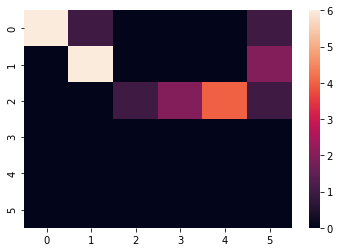

In [0]:
conf_matrix_1 = confusion_matrix(y_real, y_pred_total)
conf_matrix_2 = confusion_matrix(y_real, y_pred_wordwise)

sns.heatmap(conf_matrix_1)

In [0]:
conf_matrix_2

array([[0, 0, 0, 0, 0, 0],
       [1, 6, 1, 0, 0, 0],
       [2, 0, 6, 0, 0, 0],
       [1, 0, 0, 1, 2, 4],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

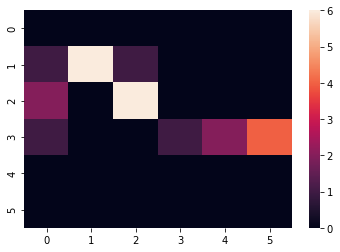

In [0]:
sns.heatmap(conf_matrix_2)

Мы видим, что самые качественные предсказания у нас происходят для классов 0 и 1. С "переносным" значением все хуже - адаграм смешивает в нем все непрямые значения этого слова.